In [1]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))

# ----------- local imports ----------- 
from utils import show_images, build_wandb_run
from sd_utils import encode_vae, decode_vae, get_prompt_embeddings
from FashionDataset import BottomCenterCrop
from constants import TRAIN_PATH, BASE_DIR

2025-03-28 04:51:13.594894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-28 04:51:13.657076: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-28 04:51:13.674212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-28 04:51:13.785899: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-28 04:51:15.744832: W tensorflow/compiler/tf2

In [2]:
import torch
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import UNet2DConditionModel, AutoencoderKL, PNDMScheduler
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)
dtype = torch.float32

In [3]:
model_id = "SG161222/Realistic_Vision_V6.0_B1_noVAE"    
vae_link = "https://huggingface.co/stabilityai/sd-vae-ft-mse-original/vae-ft-mse-840000-ema-pruned.ckpt"
inpainting_link = "https://huggingface.co/SG161222/Realistic_Vision_V6.0_B1_noVAE/blob/main/Realistic_Vision_V6.0_NV_B1_inpainting_fp16.safetensors"


scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
vae = AutoencoderKL.from_single_file(vae_link, torch_dtype=dtype).to(device)

unet = UNet2DConditionModel.from_pretrained(model_id, 
                                            subfolder="unet",
                                            torch_dtype=dtype
                                        ).to(device)

An error occurred while trying to fetch SG161222/Realistic_Vision_V6.0_B1_noVAE: SG161222/Realistic_Vision_V6.0_B1_noVAE does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [4]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=dtype)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    scheduler=scheduler,
    vae=vae,
    unet=unet,
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


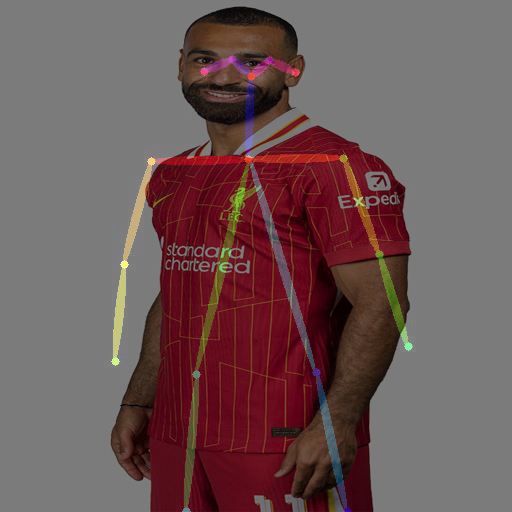

In [5]:
image_size = (512, 512)

mo_salah_img = Image.open(BASE_DIR / "mo_salah.jpg").resize(image_size, Image.BICUBIC)
straight_pose = Image.open(str(BASE_DIR / "straight_pose.jpg"))

Image.blend(mo_salah_img, straight_pose, alpha=0.5)

In [ ]:
prompt = "An ultra high-resolution, photorealistic image in 8K, A highly detailed photo, showcasing vivid colors and rich contrasts, portrait photo, perfect anatomy, 4k, high quality, full cloth"
negative_prompt = "nudity (deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime), text, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"
        
outputs = pipe(prompt = prompt, negative_prompt = negative_prompt, image = mo_salah_img)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
?pipe

Signature:     
pipe(
    prompt: Union[str, List[str]] = None,
    image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor]] = None,
    height: Optional[int] = None,
    width: Optional[int] = None,
    num_inference_steps: int = 50,
    timesteps: List[int] = None,
    sigmas: List[float] = None,
    guidance_scale: float = 7.5,
    negative_prompt: Union[str, List[str], NoneType] = None,
    num_images_per_prompt: Optional[int] = 1,
    eta: float = 0.0,
    generator: Union[torch._C.Generator, List[torch._C.Generator], NoneType] = None,
    latents: Optional[torch.Tensor] = None,
    prompt_embeds: Optional[torch.Tensor] = None,
    negative_prompt_embeds: Optional[torch.Tensor] = None,
    ip_adapter_image: Union[PIL.Image.Image, numpy.ndarray, torch.Tensor, List[PIL.Image.Image], List[numpy.ndarray], List[torch.Tensor], NoneType] = None,
    ip_adapter_image_embeds: Optional[List[torch.Tensor]] = None,
    output_t